![glassdoor](https://github.com/jasonchanhku/DataScienceDemand/blob/master/images/glassdoor.png?raw=true)

# Data Science Demand in Hong Kong
### by Jason Chan Jin An

# Introduction

This project aims to gauge the data science job demands in Hong Kong
in the past 30 days rolling based on job posts from Glassdoor. Glassdoor was 
the preferred data source because its wide array of available information:

* Job Title
* Company Name
* Link
* Company Rating
* Job Description
* Company Size
* Year Founded
* Company Type
* Industry
* Company Revenue
* CEO (sentiment)
* Recommend Percentage
* Approval Percentage

# Questions to be Answered

Exploratory Data Analysis (EDA) is performed in this notebook from a statistical and data standpoint and seeks to answer the following questions: 
* Who are hiring data scientists in Hong Kong ?
    * Big / small companies ?
    * What kind of industries ?
    * Good company feedback and approval ?
* Do company ratings differ from company types / industry / etc ?
* Given my preference of company type, which jobs suits me most ?

## Dataset

The dataset was obtained by building a python web scraper using `selenium` and the script is saved as `scraper.py` in the repository.

***

# Data Prep and Libraries

In [1]:
# Libraries used
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Data prep
df = pd.read_csv('https://raw.githubusercontent.com/jasonchanhku/DataScienceDemand/master/data/glassdoor_data.csv')
df.head()

,Title,Company,Link,Rating,Job_Description,Size,Founded,Company_Type,Industry,Revenue,CEO,Recommend,Approve
0,"CIB QR - Risk Quantitative Research, Equity De...",J.P. Morgan,https://www.glassdoor.com/partner/jobListing.h...,3.7,J.P. Morgans Corporate & Investment Bank is a ...,10000+ employees,1799,Public (JPM),Finance,$10+ billion (USD) per year,Jamie Dimon,76.0,93.0
1,Quantitative Research - M/F VIE,Societe Generale,https://www.glassdoor.com/partner/jobListing.h...,3.4,Environment\n\nYour environment\nSG CIB is the...,10000+ employees,1864,Public (GLE),Finance,$10+ billion (USD) per year,Frederic Oudea,68.0,83.0
2,Data Analyst - Modeling,Transunion,https://www.glassdoor.com/partner/jobListing.h...,3.9,Dynamics of the Role\n\nThe incumbent\nis expe...,1001 to 5000 employees,1968,Public (TRU),Finance,$1 to $2 billion (USD) per year,Jim Peck,75.0,93.0
3,Data Scientist,Lenovo,https://www.glassdoor.com/partner/jobListing.h...,3.3,Position Description\nDesign data mining and m...,10000+ employees,1984,Public (LNVGY),Information Technology,$10+ billion (USD) per year,Yang Yuanqing,57.0,64.0
4,Quantitative Researcher,Societe Generale,https://www.glassdoor.com/partner/jobListing.h...,3.4,Environment\n\nSG CIB is the Corporate and Inv...,10000+ employees,1864,Public (GLE),Finance,$10+ billion (USD) per year,Frederic Oudea,68.0,83.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 13 columns):
Title              211 non-null object
Company            211 non-null object
Link               211 non-null object
Rating             189 non-null float64
Job_Description    211 non-null object
Size               207 non-null object
Founded            207 non-null object
Company_Type       207 non-null object
Industry           207 non-null object
Revenue            207 non-null object
CEO                190 non-null object
Recommend          190 non-null float64
Approve            190 non-null float64
dtypes: float64(3), object(10)
memory usage: 21.5+ KB


# Data Preprocessing

## Exclude the following rows:
* Rows of comapny that is 'RegionUP' as they have been flagged as a scam company
* Drop rows with NA columns since insignificnat, will make it easier for machine learning
* Drop rows without CEO approval ratings since very small amount of them do not have

## Job_Description column:
* Strip leading and trailing whitespaces
* Strip '\n' from the job column description and other html tags
* Replace double space with single space

## Revenue column
* Remove unecessary parts of text
* Impute values of 'Unknown / Not Applicable' using employee size
* Preserve ordinality by mapping

## Size column
* Impute using revenue column
* Improve readability

## Company_Type column
* Remove stock tickers

### Excluding Rows

In [4]:
# Exclude outlier RegionUP as it is a scam company
df = df[df['Company'] != 'RegionUP']

# Remove NAs
df = df.dropna()

# Drop those without Approval scores
df = df[df['Approve'] != -1]

# Remove unknown size companies
df = df[df['Size'] != 'Unknown']

df.shape

(140, 13)

# Cleansing Functions

In [5]:
# Cleanse job description column
def jd_cleanse(col):
    
    col = col.apply(lambda x: x.strip())
    col = col.apply(lambda x: x.replace('\n', ' '))
    col = col.apply(lambda x: x.replace('  ', ' '))
    
    return col

# Cleanse the revenue column

def rev_cleanse(col):
    
    col = col.apply(lambda x: x.replace('per year', ''))
    col = col.apply(lambda x: x.replace('(USD)', '')) 
    col = col.apply(lambda x: x.strip())
    col = col.replace('Unknown / Non-Applicable', None)
    mapping = pd.pivot_table(df[['Size', 'Revenue']].drop_duplicates(),index=['Size'], columns=['Revenue'], aggfunc=np.count_nonzero).idxmax(axis =1)
    col.fillna(df.Size.map(mapping))
    
    return col

def col_type_cleanse(col):
    col = col.apply(lambda x: x.split('(')[0].strip())
    
    return col

def size_cleanse(col):
    col = col.apply(lambda x: x.replace('employees', '').strip())
    
    return col

def company_cleanse(col):
    col = col.apply(lambda x: x.replace('CompareAsiaGroup', 'Compare Asia Group'))
    
    return col

### Company Column

In [6]:
df['Company'] = company_cleanse(df['Company'])

### Job_Description Column

In [7]:
df['Job_Description'] = jd_cleanse(df['Job_Description'])

In [8]:
df['Job_Description'].head()

0    J.P. Morgans Corporate & Investment Bank is a ...
1    Environment Your environment SG CIB is the Cor...
2    Dynamics of the Role The incumbent is expected...
3    Position Description Design data mining and ma...
4    Environment SG CIB is the Corporate and Invest...
Name: Job_Description, dtype: object

### Revenue Column

How many are Unknown / Not Applicable ?
* Around 21 unknown revenues

In [9]:
df['Revenue'].value_counts()

$10+ billion (USD) per year                  57
Unknown / Non-Applicable                     20
$5 to $10 billion (USD) per year             18
$2 to $5 billion (USD) per year               8
$1 to $2 billion (USD) per year               8
$50 to $100 million (USD) per year            7
$100 to $500 million (USD) per year           7
$500 million to $1 billion (USD) per year     4
$10 to $25 million (USD) per year             4
$25 to $50 million (USD) per year             2
$1 to $5 million (USD) per year               2
Less than $1 million (USD) per year           2
Unknown / Non-Applicable per year             1
Name: Revenue, dtype: int64

#### Imputing Revenue by most common occrence

* Impute revenue based on most common occurence grouped by company size


### Pivot Table of Revenue mode occurence for each Size

In [10]:
mapping = pd.pivot_table(df[['Size', 'Revenue']].drop_duplicates(),index=['Size'], columns=['Revenue'], aggfunc=np.count_nonzero).idxmax(axis =1)

In [11]:
dict(mapping)

{'1 to 50 employees': '$1 to $5 million (USD) per year',
 '10000+ employees': '$10+ billion (USD) per year',
 '1001 to 5000 employees': '$1 to $2 billion (USD) per year',
 '201 to 500 employees': '$1 to $5 million (USD) per year',
 '5001 to 10000 employees': '$1 to $2 billion (USD) per year',
 '501 to 1000 employees': '$100 to $500 million (USD) per year',
 '51 to 200 employees': '$10 to $25 million (USD) per year'}

In [12]:
df['Revenue'] = rev_cleanse(df['Revenue'])

## Company_Type Column
* Removing the stock tickers

In [13]:
df['Company_Type'] = col_type_cleanse(df['Company_Type'])

## Size Column

In [14]:
df['Size'] = size_cleanse(df['Size'])

# A Look at the Data
Data now looks good to perform EDA

In [15]:
df.head()

,Title,Company,Link,Rating,Job_Description,Size,Founded,Company_Type,Industry,Revenue,CEO,Recommend,Approve
0,"CIB QR - Risk Quantitative Research, Equity De...",J.P. Morgan,https://www.glassdoor.com/partner/jobListing.h...,3.7,J.P. Morgans Corporate & Investment Bank is a ...,10000+,1799,Public,Finance,$10+ billion,Jamie Dimon,76.0,93.0
1,Quantitative Research - M/F VIE,Societe Generale,https://www.glassdoor.com/partner/jobListing.h...,3.4,Environment Your environment SG CIB is the Cor...,10000+,1864,Public,Finance,$10+ billion,Frederic Oudea,68.0,83.0
2,Data Analyst - Modeling,Transunion,https://www.glassdoor.com/partner/jobListing.h...,3.9,Dynamics of the Role The incumbent is expected...,1001 to 5000,1968,Public,Finance,$1 to $2 billion,Jim Peck,75.0,93.0
3,Data Scientist,Lenovo,https://www.glassdoor.com/partner/jobListing.h...,3.3,Position Description Design data mining and ma...,10000+,1984,Public,Information Technology,$10+ billion,Yang Yuanqing,57.0,64.0
4,Quantitative Researcher,Societe Generale,https://www.glassdoor.com/partner/jobListing.h...,3.4,Environment SG CIB is the Corporate and Invest...,10000+,1864,Public,Finance,$10+ billion,Frederic Oudea,68.0,83.0


# Exploratory Data Analysis (EDA)

## Q1: What type of companies are hiring data scientists in Hong Kong ?
* It seems like data scientist hiring is lead by Public listed companies
* Private companies coming in second with half as many job posts of Public companies

/Users/jasonchan/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


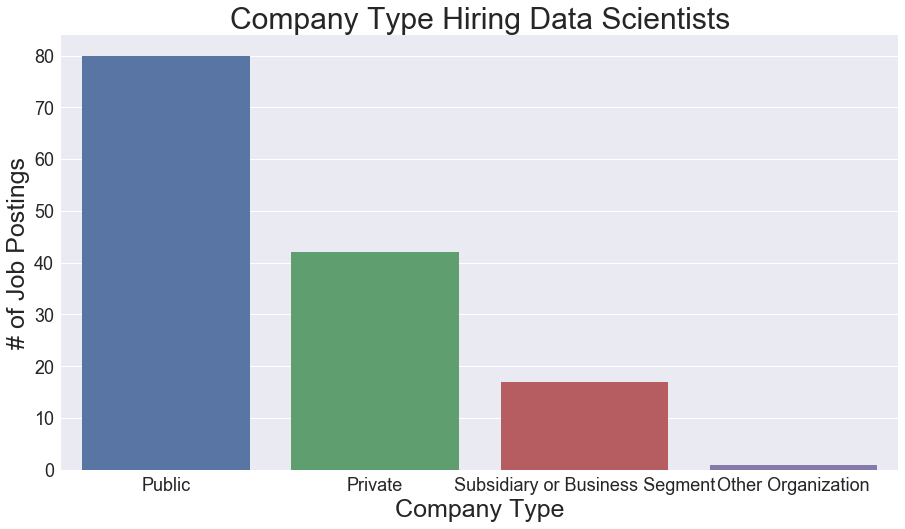

In [16]:
plt.subplots(figsize=(15, 8))
q1 = sns.countplot(x = 'Company_Type', data = df)
q1.set_title('Company Type Hiring Data Scientists', fontsize = 30)
q1.set_ylabel('# of Job Postings',fontsize = 25)
q1.set_xlabel('Company Type',fontsize = 25)
q1.tick_params(labelsize = 18)
sns.plt.show()

## Q2: Which industries are hiring data scientists in Hong Kong ?
* Not surprising that Finance industry has the most data scientist job postings, given that Hong Kong is a financial hub and these firms have the money to build their data science team
* IT industry comes in second but a huge difference indicating Finance firms are leading the hiring.

/Users/jasonchan/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


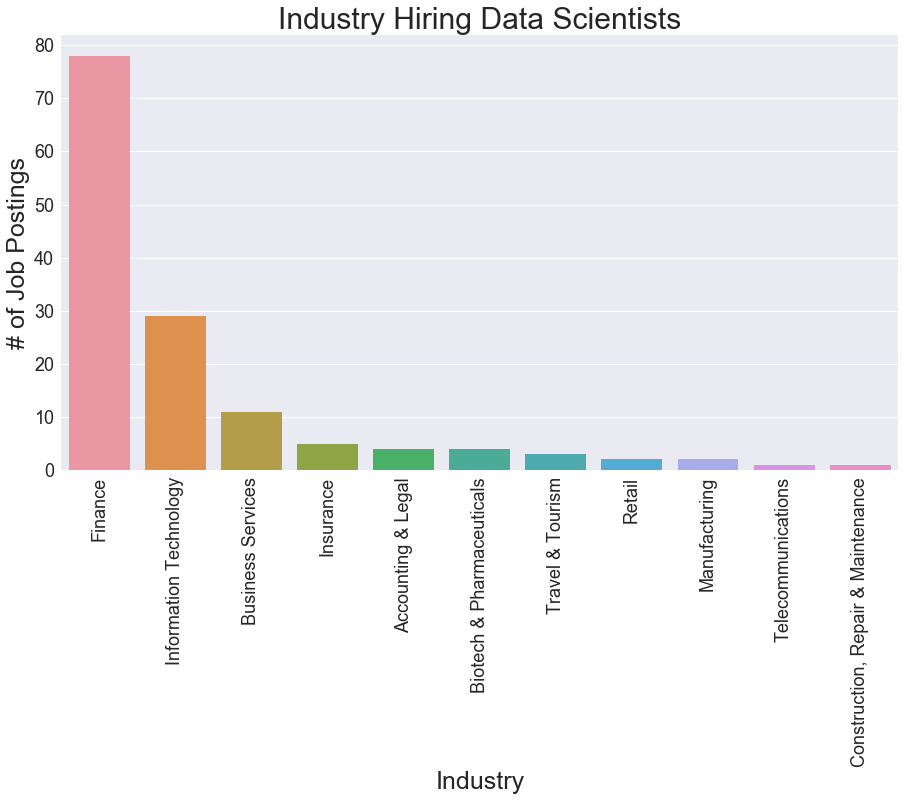

In [17]:
plt.subplots(figsize=(15, 8))
q1 = sns.countplot(x = 'Industry', data = df, order = df['Industry'].value_counts().index)
q1.set_title('Industry Hiring Data Scientists', fontsize = 30)
q1.set_ylabel('# of Job Postings',fontsize = 25)
q1.set_xlabel('Industry',fontsize = 25)
q1.tick_params(labelsize = 18)
q1.set_xticklabels(q1.get_xticklabels(),rotation=90)

sns.plt.show()

## Q3: Which are the highest rated companies hiring data scientists in Hong Kong ?
* Limiting to only top 15 companies
* Some big companies like Facebook, Johnson & Johnson, and Goldman Sachs are present

/Users/jasonchan/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


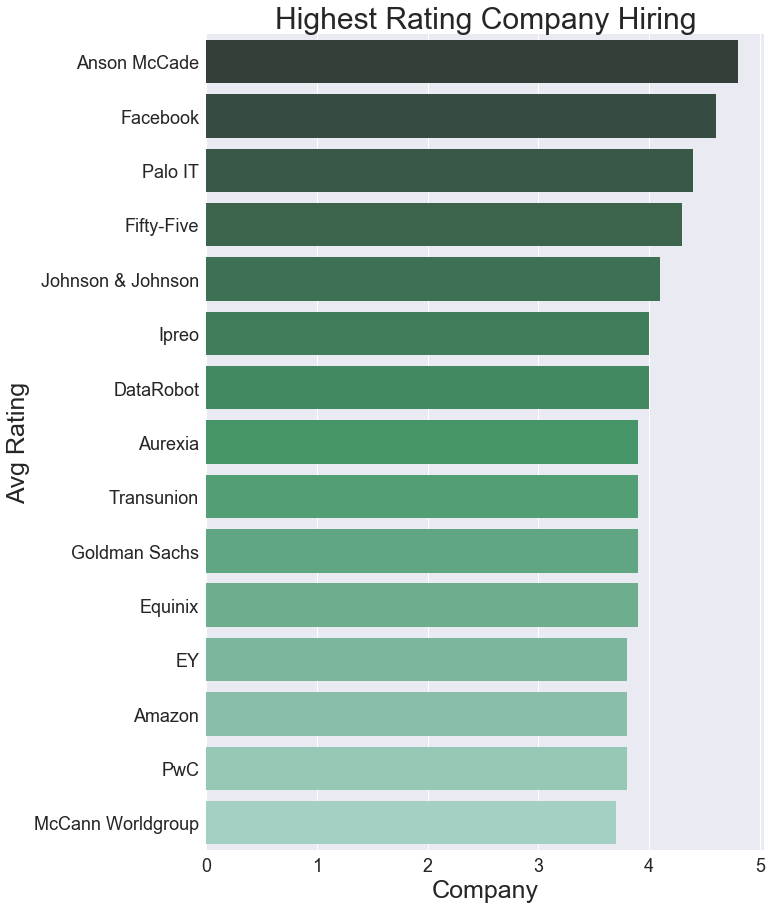

In [18]:
plt.subplots(figsize=(10, 15))
p1 = pd.pivot_table(df[['Company', 'Rating']], index = ['Company'], aggfunc=np.mean).sort_values('Rating', ascending=False)
p1 = p1.head(15)
q1 = sns.barplot(x = 'Rating', y = p1.index, data = p1, palette='BuGn_d')
q1.set_title('Highest Rating Company Hiring', fontsize = 30)
q1.set_ylabel('Avg Rating',fontsize = 25)
q1.set_xlabel('Company',fontsize = 25)
q1.tick_params(labelsize = 18)
sns.plt.show()

# Ratings

## Q4: Which companies hiring data scientists have the highest recommendation ?
* Seems pretty consistent with the list above
* Strong correlation between high rating and high recommendation

/Users/jasonchan/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


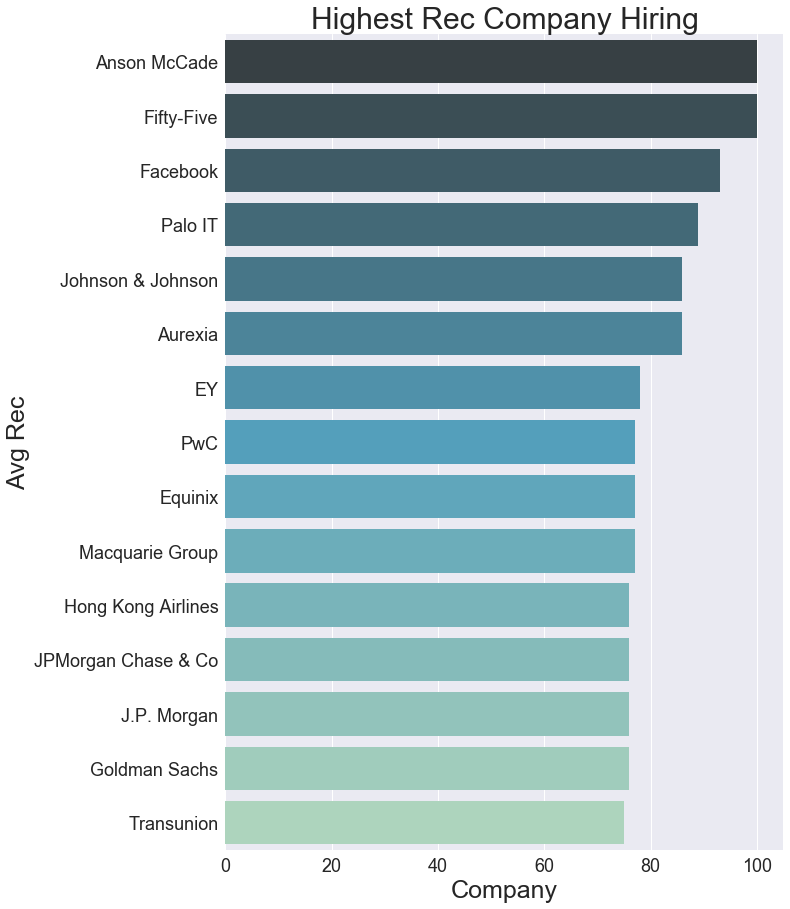

In [19]:
plt.subplots(figsize=(10, 15))
p1 = pd.pivot_table(df[['Company', 'Recommend']], index=['Company'], aggfunc=np.mean).sort_values('Recommend', ascending=False)
p1 = p1.head(15)
q1 = sns.barplot(x = 'Recommend', y = p1.index, data = p1, palette='GnBu_d')
q1.set_title('Highest Rec Company Hiring', fontsize = 30)
q1.set_ylabel('Avg Rec',fontsize = 25)
q1.set_xlabel('Company',fontsize = 25)
q1.tick_params(labelsize = 18)
sns.plt.show()

## Q5: How are the ratings across company types ?

/Users/jasonchan/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


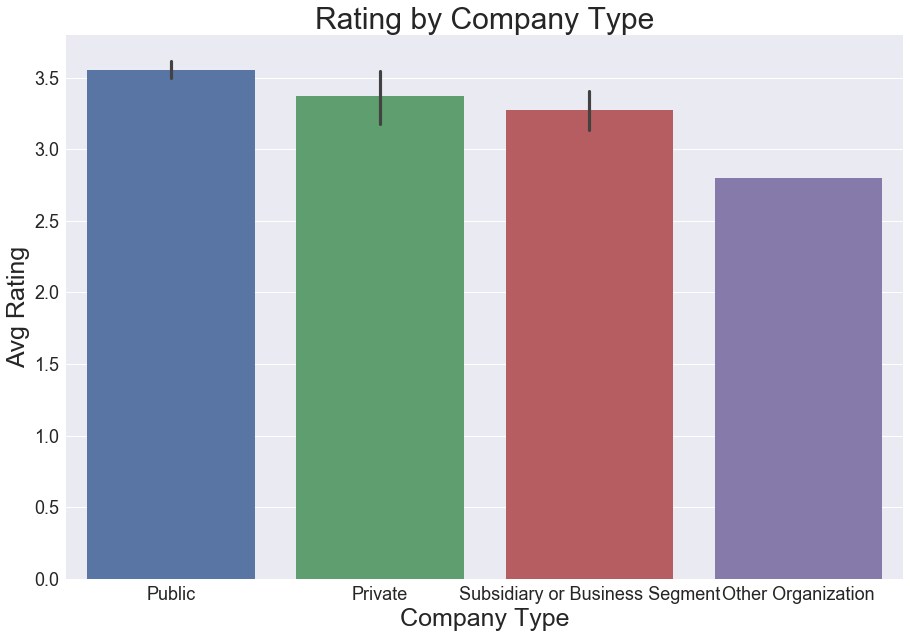

In [20]:
plt.subplots(figsize=(15, 10))
q1 = sns.barplot(x = 'Company_Type', y = 'Rating', data = df)
q1.set_title('Rating by Company Type', fontsize = 30)
q1.set_ylabel('Avg Rating',fontsize = 25)
q1.set_xlabel('Company Type',fontsize = 25)
q1.tick_params(labelsize = 18)
sns.plt.show()

## Q6: How are the ratings across industry ?
* Despite Finance being the industry with the most postings, aggregated ratings don't seem that high
* Accounting and legal, Telco, and Business Services in top 3

/Users/jasonchan/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


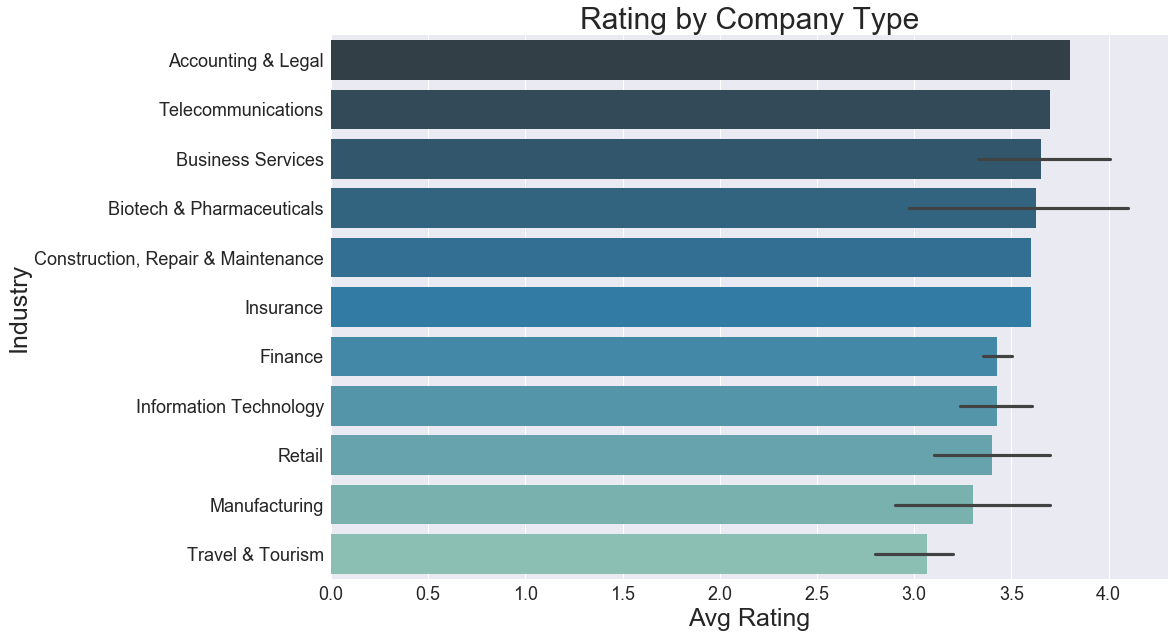

In [21]:
p1= pd.pivot_table(df[['Industry', 'Rating']], index=['Industry'], aggfunc=np.mean).sort_values('Rating', ascending=False)
plt.subplots(figsize=(15, 10))
q1 = sns.barplot(y = 'Industry', x = 'Rating', data = df, order = p1.index, palette='YlGnBu_d')
q1.set_title('Rating by Company Type', fontsize = 30)
q1.set_ylabel('Industry',fontsize = 25)
q1.set_xlabel('Avg Rating',fontsize = 25)
q1.tick_params(labelsize = 18)
sns.plt.show()

# Job Descriptions NLP
The purpose of this section is to find out:
* Which programming skills are needed
* What are the hot topics in data science recruitment 

## Further Data Cleasing
* lowercase
* remove punctuations
* single string
* Tokenization
* Stemming 
* Lemmatization

In [22]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [23]:
def tokenize(text):
    text = text.lower()
    text = re.sub('[' + string.punctuation + '0-9\\r\\t\\n]', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if len(w) > 2]
    tokens = [w for w in tokens if not w in ENGLISH_STOP_WORDS]
    return tokens 

def stemwords(words):
    #porter = PorterStemmer()
    wnl = WordNetLemmatizer()
    word = [wnl.lemmatize(w) for w in words] # stem words 
    return word

In [24]:
all_words = df['Job_Description'].values
all_words = " ".join(all_words)
all_words_stem = stemwords(tokenize(all_words))
all_words = Counter(all_words_stem)

## Overall Word Cloud

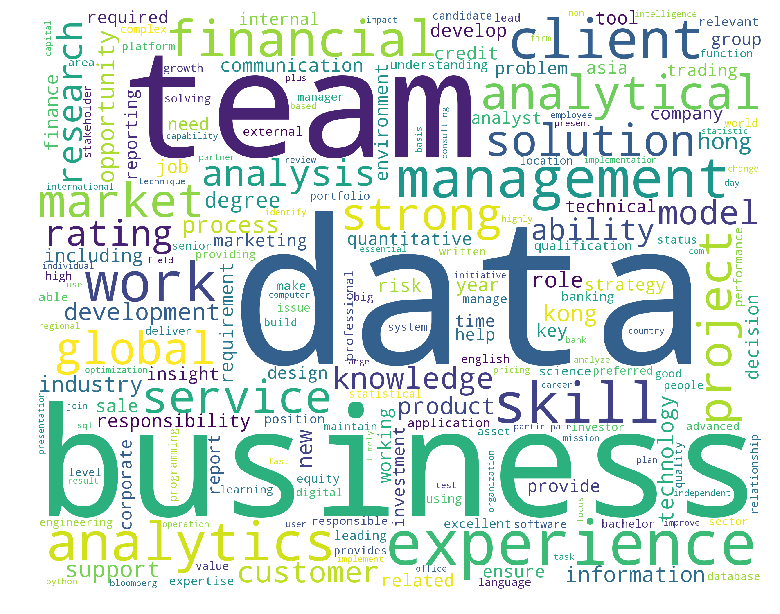

In [25]:
# cloud for all words
wordcloud = WordCloud(background_color='white', width=2500, height=2000)
wordcloud.fit_words(all_words)

fig=plt.figure(figsize=(13, 13))   # Prepare a plot 5x3 inches
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


Save the following dataframe of the wordcloud above for reference

In [26]:
common = pd.DataFrame(list(dict(all_words.most_common()).items()), columns=['Word', 'Frequency'])
common.head(15)

,Word,Frequency
0,data,710
1,business,458
2,team,446
3,experience,395
4,skill,318
5,management,316
6,work,309
7,client,301
8,analytics,290
9,financial,253


## Programming Skills Wordcloud
* In terms of programming skills, what are the tech skills most in demand ?

In [27]:
tech_skills = ['python', 'java', 'hadoop','hdfs', 'spark', 'sql', 'alteryx', 'tableau', 'qlik','qlikview', 'qliksense', 'linux', 'unix', 
               'javascript', 'php', 'ruby', 'apache', 'powerbi', 'teradata', 'excel', 'vba', 'nlp', 'aws', 'amazon',
              'cloud', 'google', 'haskell', 'algorithm']

In [28]:
all_dict = dict(all_words)
tech_dict = dict((k, all_dict[k]) for k in tech_skills if k in all_dict)
tech_cloud = Counter(tech_dict)

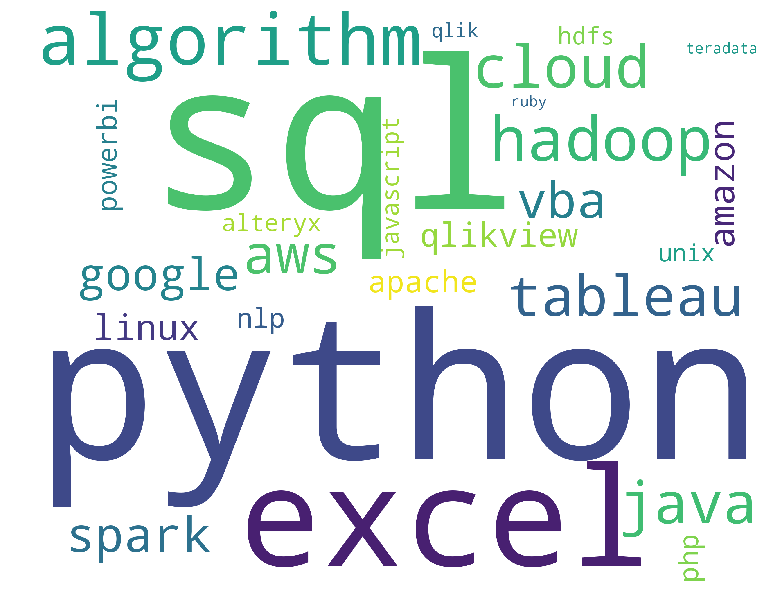

In [29]:
# cloud for tech words
wordcloud = WordCloud(background_color='white', width=2500, height=2000)
wordcloud.fit_words(tech_cloud)

fig=plt.figure(figsize=(13, 13))   # Prepare a plot 5x3 inches
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Seems like the following top 10 skills define the core skill set of data science recruitment in HK

In [30]:
tech_common = pd.DataFrame(list(dict(tech_cloud.most_common()).items()), columns=['Tech Skill', 'Frequency'])
tech_common.head(10)

,Tech Skill,Frequency
0,sql,46
1,python,44
2,excel,31
3,algorithm,31
4,hadoop,23
5,cloud,21
6,java,20
7,tableau,19
8,aws,18
9,vba,15


/Users/jasonchan/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


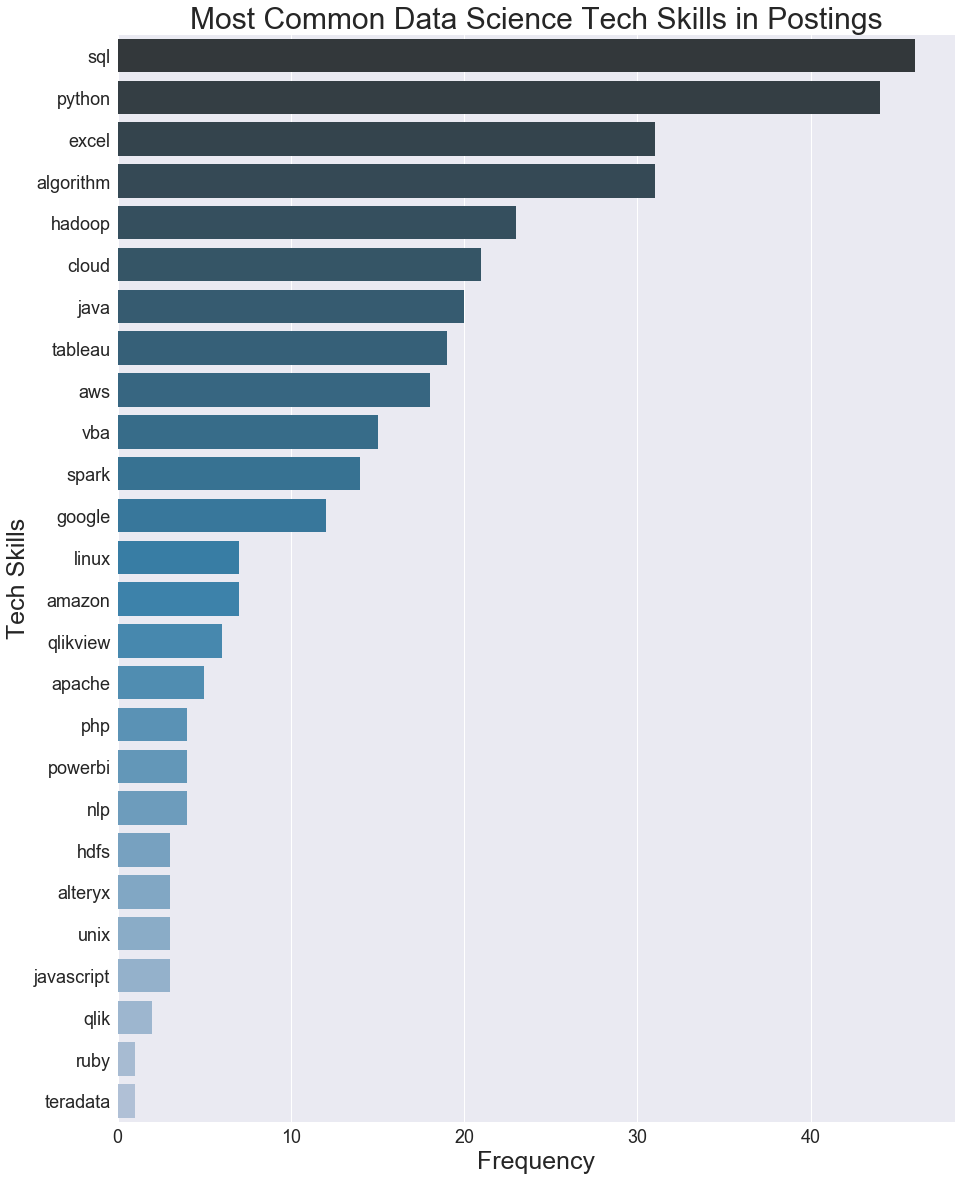

In [31]:
plt.subplots(figsize=(15, 20))
q1 = sns.barplot(x='Frequency', y = 'Tech Skill', data = tech_common, palette='PuBu_d')
q1.set_title('Most Common Data Science Tech Skills in Postings', fontsize = 30)
q1.set_ylabel('Tech Skills',fontsize = 25)
q1.set_xlabel('Frequency',fontsize = 25)
q1.tick_params(labelsize = 18)

# Entity Sentiment

From the column of CEO names, an entity sentiment can be obtained. This arguably could reflect how the CEO leads the company in the short term. For instance, one might not be fond of working for a company whose CEO is negatively perceived by the public.

In [51]:
# Imports the Google Cloud client library
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types

ContextualVersionConflict: (setuptools 27.2.0 (/Users/jasonchan/anaconda/lib/python3.6/site-packages/setuptools-27.2.0-py3.6.egg), Requirement.parse('setuptools>=34.0.0'), {'google-api-core'})

# To Do:
* entity sentiment
    * https://cloud.google.com/natural-language/
    * https://stackoverflow.com/questions/49139188/converting-google-cloud-nlp-api-entity-sentiment-output-to-json
  
* machine learning - segmentation
    * K-Means
    * Hierarchical Clustering

# Conclusion

## General

* Public listed and private companies drive the recruiting of Data Scientists
* Finance and IT industry hires the most Data Scientists, probably the budget available for a team
* Anson McCade, Facebook, Johnson & Johnson are the hightes rated companies that hires Data Scientists
* Public listed companies on average have the highest ratings

## Job Description Wordcloud

Most Data Scientists jobs requires the following element in terms of experience:

* data working experience
* analytics capabilities
* financial sector
* customer / client based data
* project management experience

## Tech Skills Wordcloud

Most Data Scientist jobs in HK needs the following skills:
* SQL
* Python
* Excel
* Machine Learning
* Cloud 
* Hadoop
* AWS
* Tableau